# Tutorial on how to measure DIBs in hot stellar spectra of LAMOST LRS

This demo Jupyter notebook can be downloaded at [GitHub](https://github.com/iScottMark/LAMOST_DIB/tutorials/).

Compared to the measurement of DIBs in cool stellar spectra, the measurement of DIBs in hot stellar spectra is **easier** because the DIBs are not blended with stellar lines. 

Refer to the paper by [Ma et al. (2025)](https://ui.adsabs.harvard.edu/abs/2025RAA....25i7001M/abstract) for more details on the method.

In [1]:
# import some necessary modules
import os
import sys
from pathlib import Path

import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

# import self-defined modules `dibkit`
sys.path.append('../')
from dibkit.core import utils
from dibkit.dib import measure, tools_6614

## Step.1: Load a hot stellar spectrum to be measured

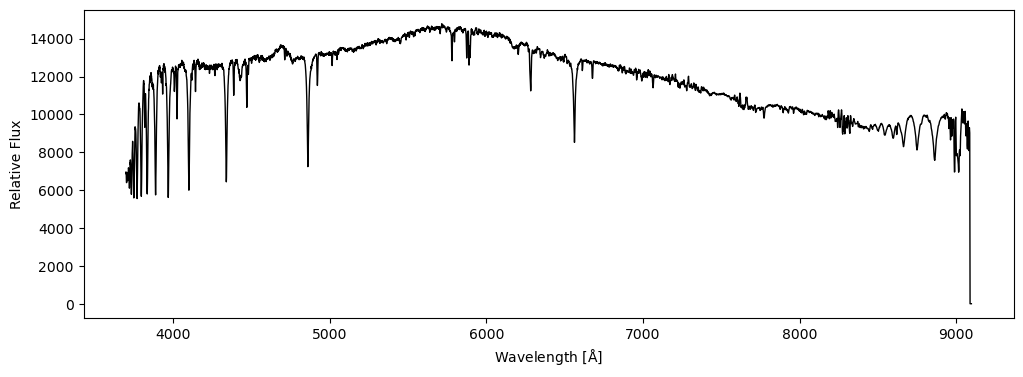

In [2]:
# Load the catalog of the hot stars from LAMOST
ROOT = '../'
catalog_name = 'hot_lamost_with_ebv_snr_gt50.fits'
catalog_path = os.path.join(ROOT, 'inputs', catalog_name)
df = Table.read(catalog_path).to_pandas()

# Read the spectrum
# select a demo star according to the unique spectra identifier in LAMOST, namely, `obsid`
obsid = 248110220
spec_info = df[df['obsid'] == obsid].iloc[0]
# get the path of the spectrum
abs_spec_path = utils.get_spec_path(spec_info, os.path.join(ROOT, 'datasets/demo_lamost_lrs_dr10_v1.0'))
# read the spectrum
wave_vac, flux, flux_norm, ivar = utils.read_fits(abs_spec_path)
# transform from vacuum to air
wave_air = utils.vac2air(wave_vac)

# Plot the spectrum
plt.figure(figsize=(12, 4))
plt.plot(wave_air, flux, c='k', lw=1)
plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
plt.ylabel('Relative Flux')
plt.show()

## Step.2: Local re-normalization to get the hot interstellar spectrum (HIS)

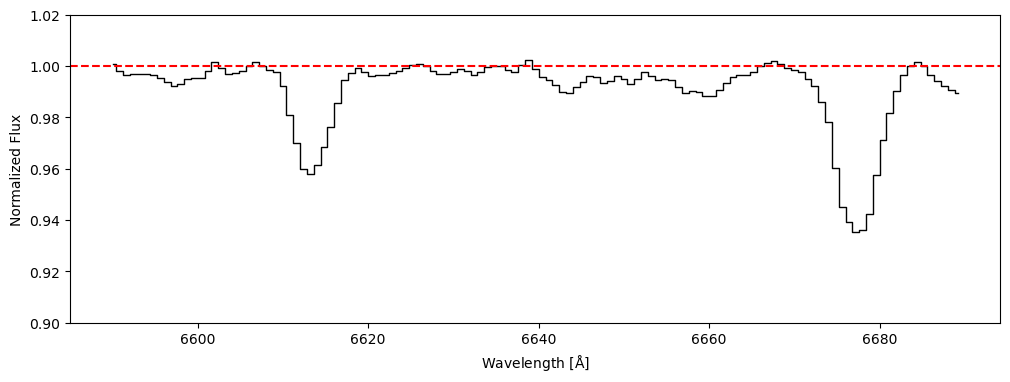

In [3]:
# Segment the spectrum within the DIB region, and rebin the spectrum to a step of 0.8 A
# define the wavelength range and step
wave_min, wave_max, step = 6590, 6690, 0.8  # for DIB 6614
# wave_min, wave_max, step = 5755, 5855, 0.8  # for DIB 5780 and 5797
dib_region = np.arange(wave_min, wave_max, step)
# truncate
wave_cut, flux_cut, ivar_cut = utils.cut_array(
    x=wave_air, y=flux, yerr=ivar, xmin=wave_min, xmax=wave_max)
# rebin
flux_rebin = utils.rebin_array(wave_cut, flux_cut, dib_region)
ivar_rebin = utils.rebin_array(wave_cut, ivar_cut, dib_region)

# Local re-normalization to the continuum
flux_cont, flux_norm = utils.specNormg(flux_rebin, order=5)
# compute the corresponding error
ivar_norm = flux_cont ** 2 * ivar_rebin
err_flux_norm = 1 / np.sqrt(ivar_norm)

# Plot the local normalized spectrum within the DIB region
plt.figure(figsize=(12, 4))
plt.step(dib_region, flux_norm, c='k', lw=1, where='mid')
plt.axhline(1, c='r', ls='--', lw=1.5)
plt.ylim(0.9, 1.02)
plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
plt.ylabel('Normalized Flux')
plt.show()

## Step.3: Measure the DIB 6614

Measurement Result:

threshold: 0.0026
is_6614_detect: 1.0000
a0_6614: 0.0420
mu0_6614: 6613.2000
a_6614_cf: 0.0428
aerr_6614_cf: 0.0003
mu_6614_cf: 6613.3498
muerr_6614_cf: 0.0148
sig_6614_cf: 1.9584
sigerr_6614_cf: 0.0148
ew_6614_cf: 0.2101
ewerr_6614_cf: 0.0021
a_6614_mc: 0.0427
aerr_6614_mc: 0.0013
mu_6614_mc: 6613.3488
muerr_6614_mc: 0.0666
sig_6614_mc: 1.9665
sigerr_6614_mc: 0.0640
ew_6614_mc: 0.2105
ewerr_6614_mc: 0.0094


/Users/mxx/Desktop/LAMOST_DIB/tutorials/../dibkit/core/utils.py:269: FutureWarning: AffineScalarFunc.__abs__() is deprecated. It will be removed in a future release.
  y = np.abs(np.sqrt(2.0 * np.pi) * u * v)


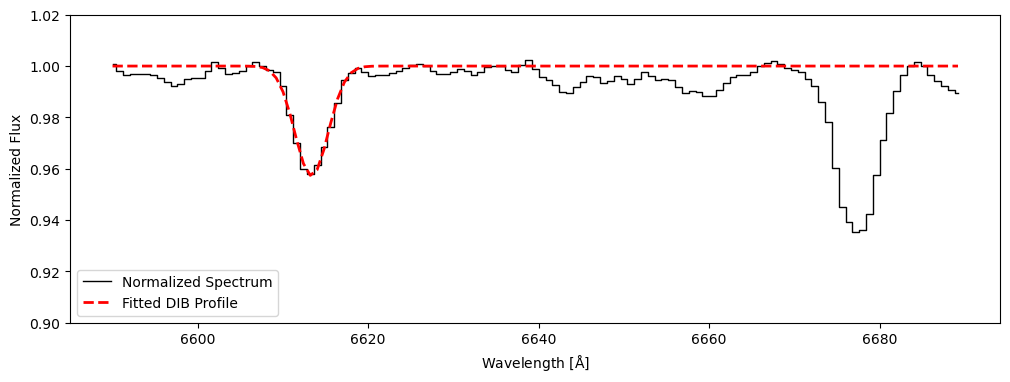

In [4]:
# The DIB 6614 measurement.
# ! However, this measurement function is highly-encapsulated.
# ! If needed, it is recommended to step into the function `measure_dib6614` to see how it works.
result = measure.measure_dib6614(
    wave=dib_region,
    flux=flux_norm,
    flux_err=err_flux_norm,
    snr=spec_info['snrr'],
)

# Print the result, which is a dictionary containing the measurement results.
print('Measurement Result:\n')
for key, value in result.items():
    print(f'{key}: {value:.4f}')

# Plot the DIB 6614 MCMC fitting result
flux_fit = tools_6614.gaussian_c(
    x=dib_region,
    a=-result['a_6614_mc'],
    b=result['mu_6614_mc'],
    c=result['sig_6614_mc'],
)

plt.figure(figsize=(12, 4))
plt.step(dib_region, flux_norm, c='k', lw=1, where='mid', label='Normalized Spectrum')
plt.plot(dib_region, flux_fit, c='r', ls='--', lw=2, label='Fitted DIB Profile')
plt.ylim(0.9, 1.02)
plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.show()